In [16]:
#Import packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
import collections
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from collections import Counter
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler

In [2]:
#Import training data
data=pd.read_csv('train.csv')

In [3]:
print(data.head())
print(data.shape)

   label   id  visitTime  purchaseTime  hour          C1          C2  \
0     -1   37   19274330            -1     0  2569487005  1830830742   
1     -1   55   19274334            -1     0  3191875643   403381353   
2     -1  114   19274353            -1     0  2634604934   403381353   
3     -1  128   19274358            -1     0  2569487005   403381353   
4     -1  164   19274367            -1     0  2569487005   403381353   

           C3         C4          C5  ...  N4  N5  N6  N7  N8  N9  N10  \
0  4228834423  652481754  2967512603  ...   0   0   0   0   0   0    0   
1  1238330876  652481754  2967512603  ...   0   0   0   0   1   0    0   
2  1928325921  652481754  2967512603  ...   0   0   0   0   0   0    0   
3   296915027  652481754  2967512603  ...   0   0   0   0   0   0    0   
4   681762206  652481754  2967512603  ...   0   0   0   0   0   0    0   

          C10         C11         C12  
0   419316267  3617851689  4220791646  
1  1968545380  3831440054  1213938795  
2 

In [4]:
for i in data.columns:
    print ("---- %s ---" % i)
    print (data[i].value_counts())

---- label ---
-1    31371
 1       57
Name: label, dtype: int64
---- id ---
399357    1
159399    1
525994    1
278189    1
448176    1
         ..
68628     1
590869    1
476883    1
5143      1
327680    1
Name: id, Length: 31428, dtype: int64
---- visitTime ---
19328699    6
19319226    6
19325796    5
19314062    5
19310993    5
           ..
19310525    1
19283902    1
19314623    1
19318721    1
19300352    1
Name: visitTime, Length: 24587, dtype: int64
---- purchaseTime ---
-1           31371
 19307708        1
 19319002        1
 19306613        1
 19298361        1
 19330955        1
 19318637        1
 19324431        1
 19295049        1
 19331883        1
 19325720        1
 19344902        1
 19331996        1
 19325359        1
 19323160        1
 19327407        1
 19327835        1
 19323177        1
 19300350        1
 19344084        1
 19345863        1
 19312951        1
 19304723        1
 19335360        1
 19337379        1
 19302544        1
 19325069        1


In [5]:
#Data Cleaning
features=data
total = features.isnull().sum().sort_values(ascending=False)
percent_1 = features.isnull().sum()/features.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(6)

,Total,%
C12,0,0.0
C8,0,0.0
id,0,0.0
visitTime,0,0.0
purchaseTime,0,0.0
hour,0,0.0


Feature engineering

In [6]:
X=data.drop(["label","purchaseTime"], axis=1)
y=data['label']

In [7]:
X=X.drop(["C1","C12","C3","C11","C6","C10","C4","C5","id","N1","N2","N5","N7","hour","visitTime"], axis=1, errors="ignore")

In [8]:
#Dummifying columns, dropping the original and the first dummy
#X=pd.get_dummies(X, columns=["C7","C9","C8","C2"], drop_first=True)

In [9]:
to_normalize=["N9","N10","N8","N4","N3","N6"]
#For loop to normalize by min-max values
for i in to_normalize:
    x= X[[i]].values
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    X[i]=x_scaled

In [10]:
X.shape

(31428, 10)

Modeling

In [11]:
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.33, stratify=y)

In [17]:
# Over sampling followed by undersampling
print('Original dataset shape %s' % Counter(y_train))
sm=SMOTE(random_state=42, sampling_strategy=0.1)
X_res, y_res=sm.fit_resample(X_train,y_train)
cc = RandomUnderSampler(random_state=42, sampling_strategy=0.9)
X_res, y_res = cc.fit_resample(X_res,y_res)
print('Resampled dataset shape %s' % Counter(y_res))

Original dataset shape Counter({-1: 21018, 1: 38})
Resampled dataset shape Counter({-1: 2334, 1: 2101})


Logistic Regression

In [18]:
logmodel=LogisticRegression()
logmodel.fit(X_res,y_res)
predictions = logmodel.predict(X_test)

In [19]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

          -1       1.00      0.76      0.86     10353
           1       0.00      0.63      0.01        19

    accuracy                           0.76     10372
   macro avg       0.50      0.69      0.44     10372
weighted avg       1.00      0.76      0.86     10372



In [20]:
confusion_matrix(predictions,y_test)

array([[7844,    7],
       [2509,   12]], dtype=int64)

Random Forest

In [21]:
# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42, max_depth=1)
# Train the model on training data
rf.fit(X_res, y_res);

In [22]:
predictions = rf.predict(X_test)

In [23]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00     10353
           1       0.24      0.79      0.37        19

    accuracy                           1.00     10372
   macro avg       0.62      0.89      0.68     10372
weighted avg       1.00      1.00      1.00     10372



In [24]:
confusion_matrix(predictions,y_test)

array([[10306,     4],
       [   47,    15]], dtype=int64)

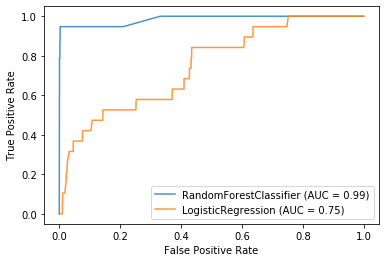

In [23]:
ax = plt.gca()
rf_disp = plot_roc_curve(rf, X_test, y_test,ax=ax, alpha=0.8)
lr_disp = plot_roc_curve(logmodel, X_test, y_test,ax=ax, alpha=0.8)
plt.show()

In [25]:
predictions = rf.predict(X_res)

In [26]:
confusion_matrix(predictions,y_res)

array([[2325,   24],
       [   9, 2077]], dtype=int64)

In [27]:
print(classification_report(y_res,predictions))

              precision    recall  f1-score   support

          -1       0.99      1.00      0.99      2334
           1       1.00      0.99      0.99      2101

    accuracy                           0.99      4435
   macro avg       0.99      0.99      0.99      4435
weighted avg       0.99      0.99      0.99      4435



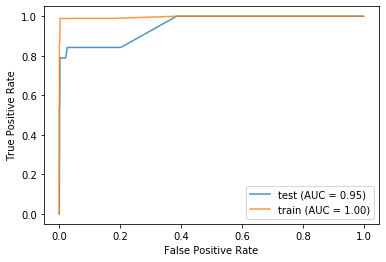

In [28]:
ax = plt.gca()
test_rf = plot_roc_curve(rf, X_test, y_test,ax=ax, alpha=0.8, name="test")
train_rf = plot_roc_curve(rf, X_res, y_res,ax=ax, alpha=0.8, name="train")
plt.show()

Selecting features based on importance in Random forest

In [29]:
features_rf = {}
for A, B in zip(X.columns.to_numpy(), rf.feature_importances_):
    features_rf[A] = B
features_rf={k: round(v,3) for k, v in sorted(features_rf.items(), key=lambda item: item[1],reverse=True)}
features_rf

{'N9': 0.31,
 'N10': 0.243,
 'N8': 0.162,
 'N6': 0.141,
 'N4': 0.063,
 'N3': 0.056,
 'C7': 0.022,
 'C9': 0.003,
 'C2': 0.0,
 'C8': 0.0}

In [30]:
fit=[]
for key, value in features_rf.items():
    if float(value)>0.007:
        fit.append(key)

Now let's fit the model to the test dataset

In [31]:
tst=pd.read_csv('test1.csv')

In [32]:
tst

,label,id,visitTime,purchaseTime,hour,C1,C2,C3,C4,C5,...,N4,N5,N6,N7,N8,N9,N10,C10,C11,C12
0,-1,1,19360733,-1,0,2569487005,403381353,681762206,652481754,2967512603,...,0,0,0,0,0,0,0,2128770044,3617851689,4220791646
1,-1,2,19360734,-1,0,2416811818,1235983246,3653557526,652481754,2116767313,...,0,0,0,0,0,0,0,4256459078,2379633508,1284343215
2,-1,3,19360735,-1,0,3765056181,1235983246,1310333812,652481754,2116767313,...,0,0,0,0,0,0,0,2840358457,3831440054,1213938795
3,-1,4,19360737,-1,0,955802445,403381353,2290282995,652481754,2967512603,...,0,0,0,0,0,0,0,4039873369,535829057,3828748840
4,-1,5,19360752,-1,0,2569487005,2517724481,2463986301,2308170622,2967512603,...,0,0,0,0,0,0,0,907610626,3617851689,4220791646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32081,-1,32082,19446873,-1,23,2569487005,2018710401,887116886,652481754,2967512603,...,0,0,0,0,0,0,0,1546561973,3617851689,4220791646
32082,-1,32083,19446914,-1,23,2569487005,403381353,3475347077,652481754,2967512603,...,0,0,0,0,0,0,0,3227742820,3617851689,4220791646
32083,-1,32084,19446925,-1,23,2569487005,403381353,3475347077,652481754,2967512603,...,0,0,0,0,0,0,0,4069315994,3617851689,4220791646
32084,-1,32085,19446931,-1,23,2569487005,2541203883,448895441,2308170622,2967512603,...,0,0,0,0,0,0,0,2724771230,3617851689,4220791646


In [33]:
to_normalize=["N9","N10","N8","N4","N3","N6"]
#For loop to normalize by min-max values
for i in to_normalize:
    x= tst[[i]].values
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    tst[i]=x_scaled

In [34]:
tst=tst.drop(["C1","C12","C3","C11","C6","C10","C4","C5","id","N1","N2","N5","N7","hour","visitTime", "label", "purchaseTime"], axis=1, errors="ignore")

In [35]:
a=tst.columns.tolist()
b=X.columns.tolist()
for i in range(len(a)):
    if a[i] in b:
        next
    else:
        print(a[i],"Not in list" )

In [36]:
#If number of features is not the same, use the above code to match, and then delete/ add if needed
print(X.shape)
print(tst.shape)

(31428, 10)
(32086, 10)


In [37]:
predictions = rf.predict(tst)
tst["label"]=predictions

In [38]:
out=tst[["label"]]
out["id"]=out.index
out.rename(columns={112319663760:"id"}, inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [39]:
out

,label,id
0,-1,0
1,-1,1
2,-1,2
3,-1,3
4,-1,4
...,...,...
32081,-1,32081
32082,-1,32082
32083,-1,32083
32084,-1,32084


In [40]:
out.to_csv("Aniruddha_Mahato_e197592.csv")